# Regulator Sizing for Bottle Blowdown
### Introduction
That damn Russian guy, Konstantin Tsiolkovsky, tells us that every gram counts. Thus overarching design goal for a cold-gas Reaction Control System is to find the minimum system mass that meets the GNC requirements (total impulse, minimum thrust, etc). Things that most strongly impact the mass are the bottle volume/mass, loaded pressurant mass, and the regulator and valve selections. 

To optimally size the regulator some iterative analysis is required. This tool is used to find the range of standard volumetric flow rates $\dot{V}_{SCFM}$, total impulse, and minimum thrust for a design given the design inputs below.

| Design Input | Description | Unit |
|:---|---:|---:|
|fluid| pressurant gas (e.g. Nitrogen, Helium, ...)||
|$p_0$ | tank inital pressure| psia|
|$T_0$ | tank inital temperature| K|
|volume | tank volume| m$^3$|
|$Q$ | heat transfer to tank| W|
|$C_d$ | nozzle discharge coefficient||
|$p_e$ | ambient pressure| Pa|
|$A$ | throat area| m$^2$|
|$\dot{m}$ | mass flow rate from tank| kg/s|
|$p_{reg}$| regulator set-pressure| psia|
|duty | control-valve duty cycle|%|
|accel | tank acceleration| g's|

### How to use
1. Determine/play with the design variables until meet GNC total impulse and minimum thrust requirements.
2. Given the desired control pressure range (reg set pressure), and max inlet pressure pick the smallest (lowest Cv) applicable reg from a vendor catalog
3. Look at the minimum and maximum V_scfm; these are the required flow rates. Compare to reg flow curve showen in the vendor catalog given the pressure control range, the minimum and maximum inlet pressure, and reg Cv. Verify that both flowrates fall in the nominal part of the curve (i.e. outside of the choked and seat-load regions).
4. If the required flow rates dont fit on the reg the flow curve (vertically shifted according to the set-pressure) either (a) return to step 1, or (b) increment up the reg Cv and return to step 3.
5. ????
6. Profit

### A few points about reg sizing
- Sizing a regulator based on Cv alone tends to lead to an undersized reg. This is because reg Cv's are determined only at the full open, choked condition. Preferrably the reg is sized such that the range of required flow rates (demand) are in the middle of the reg flow curve, away from the seat-load/lockup and choked regions. A simple rule of thumb might be to just pick a reg with Cv 2X higher than required.
- The required regulator demand is determined by choked flow through a downstream metering orifice/rocket nozzle
- Thus reg sizing depends on flow state variables (temperature, pressure)
- Thus tank thermodynamic state as well as regulator droop, J-T effect, and Supply Pressure Effect need to be captured to ensure the reg is sized for the required demand, and total impulse requirements are met.
- For the design to not be overly conservative the control valve duty cycle (which affects reg demand), and heat transfer from the bottle to the pressurant gas (which affects internal energy and flow enthalpy, thus temperature and pressure) also need to be considered
- Reg mass tends to scale with Cv

In [24]:
from scipy.integrate import solve_ivp
import numpy as np
from CoolProp.CoolProp import PropsSI, PhaseSI
import pint
from scipy import signal
#from scipy.signal import resample, resample_poly
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

# Constants
R = 8.31446261815324 # gas constant, J/K/mol
g = 9.81 # standard gravitational acceleration, m/s

ureg = pint.UnitRegistry()

def convert_units(inpt, outpt_unit, **kwargs):
    """Convert units with pint. Output is always a magnitude. 
    If quantity already has units a specified input unit (string) 
    is not required.
    """
    
    try:
        outpt = inpt.to('{}'.format(outpt_unit))
    except:
        inpt = inpt * ureg('{}'.format(kwargs['inpt_unit']))
        outpt = inpt.to('{}'.format(outpt_unit))
    return outpt.magnitude

def get_gamma_funcs(p_e, T_0, fluid):
    """ Calculate functions of the ratio of specific heats, gamma.
    
    **Note** model assumes calorically perfect gas so this function 
    is only evaluated at the inital temperature.
    """
    
    gamma = (PropsSI('C', 'P', p_e, 'T', T_0, '{}'.format(fluid)) / 
             PropsSI('Cvmass', 'P', p_e, 'T', T_0, '{}'.format(fluid))) # ratio of specific heats
    g1 = gamma / (gamma - 1)
    g2 = (gamma - 1) / gamma
    g3 = 2 * g1
    g4 = gamma * (2 / (gamma + 1))**((gamma + 1)/(2 * (gamma - 1)))
    return gamma, g1, g2, g3, g4

def pwm(t, **kwargs):
    """Mass flow rate can be scaled by PWM duty cycle if desired. 
    Pass the option keyword arg 'duty' to main(), otherwise duty=1 is the default.
    """

    if 'duty' in kwargs.keys():
        duty = kwargs['duty']
    else:
        #sig = np.sin(2 * np.pi * t)
        #duty = (sig + 1)/2
        duty = 1.0
    #pwm = 0.5 * signal.square(2 * np.pi * 30 * t, duty=duty) + 0.5

    # nm, just return simple scaling (assume thermo state vars are sufficently averaged in time)
    return np.array([duty])

def choked_mdot(p_c, T_c, g1, g2):
    """Chocked flow mass flow rate."""
    
    return Cd * A * p_e * np.sqrt(2 / (R * T_c) * g1 * (p_c / p_e)**g2 * 
                                  (1 + (p_e / p_c)**g2))

def choked_p_c(mdot, T_c, g0, g4):
    """Choked chamber pressure given mass flow rate."""
    
    return mdot * (g0 * R * T_c)**(1/2) / (Cd * A * g4)

def get_m_dot(x1, x2, inpt, p, T, g0, g1, g2, g4, **kwargs):
    """Calculates mass flow rate from a choked square edged orifice. 
    Can use p-T or u-m as state variables. If regulator set pressure p_reg, 
    is passed in kwargs this pressure will be used instead of the tank pressure. 
    This also models J-T insenthalpic temperature change across the reg (if using a reg).
    
    **Note** there are no pressure drops modelled in the system, but they do exist in reality
    (e.g. tubes, control valves).
    
    TODO
    double check eqn (valid for choked flow)
    """
    
    # internal energy-density state vars are used by integrator
    if inpt == 'um':
        u, m = x1, x2

        if 'p_reg' in kwargs.keys():
            # use iterative solver here
            mdot, p_c, T_c = solve_flow(u, m, T, p, g0, g1, g2, g4, **kwargs)
            global mdot0, T_c0, p_c0
            mdot0, T_c0, p_c0 = mdot, T_c, p_c
        else:
            p_c = p
            T_c = T
            mdot = choked_mdot(p_c, T_c)

    # pressure-temperature vars are used by thrust()
    elif inpt == 'pT':
        p_c, T_c = x1, x2
        mdot = choked_mdot(p_c, T_c)
    
    return mdot, p_c, T_c

def solve_flow(u, m, T_t, p_t, g0, g1, g2, g4, **kwargs):
    """Iteratively solves for p_c, T_c and mdot given the orifice function, 
    flow curve function, supply pressure effect function, and J-T effect function.
    """
    fc = get_flow_curve(p_t, kwargs['fclib'])
    temp = interp1d(fc[:,0], fc[:,1])
    p_fc = lambda mdot, p_t: temp(mdot) + spe(p_t, **kwargs)
    def f(x, *args):
        u, m, T_t, p_t, g0, g1, g2, g4 = args
        mdot, p_c, T_c = x
        return np.array([choked_mdot(p_c, T_c, g1, g2) - mdot, 
                         p_fc(mdot, p_t) - p_c, 
                         jt_dT(u, m, T_t, p_t, p_c) - T_c])
    # if choked mdot = max(fc[:, 0]), p_c is s.t. mdot=mdot, need to write an inverse function for mdot
    def f_choked(x, *args):
        u, m, T_t, p_t, g0, g1, g2, g4, mdot = args
        p_c, T_c = x
        return np.array([choked_p_c(mdot, T_c, g0, g4) - p_c, 
                         jt_dT(u, m, T_t, p_t, p_c) - T_c]) 
    
    global mdot0, p_c0, T_c0
    guess = [mdot0, p_c0, T_c0]
    args = (u, m, T_t, p_t, g0, g1, g2, g4)
    try:
        flowvars = fsolve(f, guess, args=args)
    except ValueError:
        global flag
        #print('Reg is choked')
        #flag = 0
        #print(convert_units(p_c0 * ureg.pascal, 'psi'),
        #      scfm(mdot0,'to',fluid),
        #      convert_units(p_t * ureg.pascal, 'psi'))
        mdot = np.max(fc[:, 0])
        guess = [p_c0, T_c0]
        args = (u, m, T_t, p_t, g0, g1, g2, g4, mdot)
        flowvars = fsolve(f_choked, guess, args=args)
        flowvars = np.append(mdot, flowvars)
    return flowvars

def spe(p, **kwargs):
    """Supply Pressure Effect (SPE)
    Value of c from Swagelok KCP regulator, Cv = 0.2, 
    pressure control range = up to 500 psia.
    https://www.swagelok.com/downloads/webcatalogs/EN/MS-02-230.PDF
    """
    
    c = 0.145
    dP = kwargs['p_0'] - p
    return c * dP

def jt_dT(u, m, T, p, p_c): 
    """Can determine J-T effect temperature chage as dT = mu * dP where
    mu = partial(T)/partial(P)|H    (aka J-T coefficient)
    
    May be more accurate and computationally efficient to just look up the temperature
    given the upstream enthalpy and downstream pressure
    """
    
    #mu = PropsSI('d(T)/d(P)|H', 'U', u, 'D', m/volume, '{}'.format(fluid))
    #return T + mu * (p_reg - p)
    h = PropsSI('H', 'U', u, 'D', m/volume, '{}'.format(fluid)) # upsteam enthalphy, J/kg
    return PropsSI('T', 'H', h, 'P', p_c, '{}'.format(fluid)) # downstream temperature, K

def thrust(p, T, u, m, t, fluid, g0, g1, g2, g3, g4, **kwargs):
    """For plots calculates thrust developed by an equivalent choked orifice. 
    Assumes perfectly expanded, thus no pressure thrust.
    """
    
    if 'p_reg' in kwargs.keys():
        #p_c = kwargs['p_reg']
        #p_c = spe(p, **kwargs)
        #T_c = jt_dT(u, m, T, p, p_c)
        mdot, p_c, T_c = get_m_dot(u, m, 'um', p, T, g0, g1, g2, g4, **kwargs)

    else:
        p_c = p
        T_c = T
        mdot, p_c, T_c = get_m_dot(p_c, T_c, 'pT', p, T, g0, g1, g2, g4, **kwargs)

    mdot *= pwm(t, **kwargs) # Mass flow rate, kg/s
    M = PropsSI('M', '{}'.format(fluid)) # Molar mass, kg/mol
    V_e = np.sqrt(g3 * R * T_c / M * (1 - (p_e / p_c)**g2)) # Exhaust velocity, m/s
    return mdot * V_e, mdot, T_c, p_c
                                          
def p_fun(u, m): return PropsSI('P', 'U', u, 'D', m/volume, '{}'.format(fluid))

def T_fun(u, m): return PropsSI('T', 'U', u, 'D', m/volume, '{}'.format(fluid))

def heat_transfer(T, p, m, fluid, solver=False, **kwargs):
    """Heat added to the CV is set either by the optional keyword arg 'Q', or if none is 
    provided the heat transfer is calculated as turbulent natural convection assuming 
    constant wall temperature (large thermal mass compared to gas in CV). Values of 
    C, n are for internal free convection inside a vertical cylinder per McAdams, 
    "Heat Transmission", 1954. Characteristic length, L, is taken to be the diameter 
    of a sphere of equivalent volume.
    
    **Note** this is a long lever and is probably only order of magnitude correct. 
    A good place to improve
    """
    
    if 'Q' in kwargs.keys():
        # catch constant heat flux cases
        try:
            q = kwargs['Q'] * np.ones(len(p))
        except TypeError:
            q = kwargs['Q']
    else:
        T_0, A_sphere, L = kwargs['T_0'], kwargs['A_sphere'], kwargs['L']
        if 'accel' in kwargs.keys():
            accel = kwargs['accel']
        else:
            accel = 1.
        
        # catch discontinuities in fluid properties near the saturation line
        try:
            # calc fluid properties
            k = PropsSI('L', 'P', p, 'T', T, '{}'.format(fluid)) # thermal conductivity, W/K
            C = 0.168
            n = 0.33
            beta = 1 / T # thermal expansion coefficient, K^(-1)
            density = m / volume
            nu = (PropsSI('V', 'P', p, 'T', T, '{}'.format(fluid)) / 
                  density) # kinematic viscosity, m^2/s
            
            # calc dim'less groups
            Pr = PropsSI('Prandtl', 'P', p, 'T', T, '{}'.format(fluid)) # Prandtl number
            Gr = accel * g * beta * (T_0 - T) * L * L * L / nu / nu # Grashof number
            Ra = Pr * Gr # Rayleigh number
            #if Ra > 10E8:
            #    C = 0.14
            #    n = 0.33
            #else:
            #    C = 1.15
            #    n = 0.22
            h = k / L * C * Ra**n # heat transfer coefficent, W/m^2/K
            q = h * A_sphere * (T_0 - T) # heat transfer, W
        except ValueError as err:
            print(err)
            global flag
            print('Tank state is approaching the saturation line.')
            flag = 0
            if solver == True:
                q = np.array([3E3])
    return q

def dfunc(t, w, params):
    """System of differential equations to be integrated:
       dm/dt = -mdot (conservation of mass)
       du/dt = -mdot/m * (2*u + p*vol/m) + Q/m (conservation of energy)
       
       where, 
       m -- mass in control volume (CV)
       u -- specific internal energy of gas in CV
       p -- pressure of gas in CV
       mdot -- mass flow rate of gas out of CV
       vol  -- tank volume
       Q    -- heat transfer to gas CV
    """
    
    # unpack state vars and parameters
    volume, g0, g1, g2, g4, Cd, R, p_e, A, T_0 = params[0]
    kwargs = params[1]
    m, u = w
    
    # Check if two-phase
    global flag
    if PhaseSI('U', u, 'D', m/volume, '{}'.format(fluid)) == 'twophase':
        print('Tank state is approaching the saturation line.')
        flag = 0

    p = p_fun(u, m) # tank pressure, Pa
    T = T_fun(u, m) # tank temperature, K
    
    # Check if tank pressure <= reg pressure or <= 550 psi
    if p < 3.80E6:
        print('Tank pressure has fallen below 550 psi.')
        flag = 0
        
    if 'p_reg' in kwargs.keys():
        if p < kwargs['p_reg']:
            print('Tank pressure has dropped to reg set pressure.')
            flag = 0
            
    # add heat transfer
    Q = heat_transfer(T, p, m, fluid, solver=True, **kwargs)
        
    # add mass transfer
    if 'mdot' in kwargs.keys():
        mdot = kwargs['mdot']
    else:
        mdot = get_m_dot(u, m, 'um', p, T, g0, g1, g2, g4, **kwargs)[0] * pwm(t, **kwargs)
    
    # system of equations to be solved
    f0 = -mdot
    f1 = -mdot / m * (2 * u + p * volume / m) + Q / m
    return [f0, f1]

def get_sim(p_0, T_0, Cd, p_e, A, fluid, ureg, **kwargs):
    """Calls the scipy solve_ivp LSODA solver. Integration can be 
    terminated in several ways: mass = 0, tank pressure drops below
    either some threshold pressure or below the reulated pressure whichever is higher, or
    finally the thermodynamic state of the gas in the CV approaches the saturation line.
    """
    
    # Fix input units
    p_0 = convert_units(p_0, 'pascal')
    
    # Initial conditions
    m_0 = PropsSI('D', 'T', T_0, 'P', p_0, 'SRK::{}'.format(fluid)) * volume # kg
    u_0 = PropsSI('U', 'T', T_0, 'P', p_0, 'SRK::{}'.format(fluid)) # J/kg

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    stoptime = 60.0
    numpoints = 250

    # Create the time samples for the output of the ODE solver.
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    t = np.array(t)

    # Pack up the parameters and initial conditions:
    g0, g1, g2, g3, g4 = get_gamma_funcs(p_e, T_0, fluid)
    kwargs['T_0'] = T_0
    kwargs['p_0'] = p_0
    L = (volume * 3 / (4 * np.pi))**(1/3) 
    kwargs['L'] = 2 * L
    kwargs['A_sphere']  = 4 * np.pi * L * L
    params = [[volume, g0, g1, g2, g4, Cd, R, p_e, A, T_0], kwargs]
    w0 = [m_0, u_0]
    
    # add global vars for interative solver initial guess
    global p_c0, T_c0, mdot0
    p_c0, T_c0 = kwargs['p_reg'], T_0
    mdot0 = choked_mdot(kwargs['p_reg'], T_0, g1, g2)
    
    # Define termination events 
    # (e.g. tank empties, pressure < threshold, or two-phase sat mixture)
    def empty_tank(t, w, *args): return w[0]
    empty_tank.terminal = True
    empty_tank.direction = -1
    
    def limit(t, y, *args):
        """Hack-y implimentation of general purpose event. Returns 0 
        to solve_ivp if the global var flag is  ever True. **Note** normally 
        the solve_ivp 'events' only look for zeros of state variables.
        """
        
        global flag
        if flag == 1:
            test = 1
        else:
            test = 0
        return test
    limit.terminal = True  
    global flag
    flag = 1

    print('Starting simulation.')
    # Call the ODE solver
    sol = solve_ivp(dfunc, [0., stoptime], w0, t_eval=t, method='LSODA',
                     args=(params,), events=(empty_tank, limit,),
                     atol=abserr, rtol=relerr, dense_output=False)
    
    # print solution exit status
    if sol.status == 1:
        print('Success, termination event occured.')
    if sol.status == 0:
        print('Success, t end reached.')
    return sol, t, params

def scfm(x, inpt, fluid):
    """ 
    Volumetric flow rate in units commonly used to size regulators (SCFM)
    fg is a density conversion factor (reg flow charts usually assume GN2, 
    need a conversion if a different fluid, say GHe, is used)
    """
    
    rho_n2_std = 1.1656783125771475 # kg/m^3
    rho = PropsSI('D', 'P', 101E3, 'T', 292, '{}'.format(fluid))
    fg = np.sqrt(rho_n2_std / rho)
    if inpt == 'to':
        output = 2119 * x / rho * fg
    elif inpt == 'from':
        output = x / 2119 * rho / fg
    return output

def get_scaled_line(t_y, b_y, t_x, b_x, scale, p_t, p_b, **kwargs):
    """Interpolate a curve between two flow curves at given
    inlet pressures. t_y, t_x refer to the y and x coordinate
    respectively of the 'top' curve, whereas b_y, and b_x refer
    to the bottom curve.
    """
    
    # upsample using interp1d
    if len(t_x) > len(b_x):        
        f = interp1d(b_x, b_y)
        b_x = np.linspace(b_x[0], b_x[-1], len(t_x))
        b_y = f(b_x)
    elif len(t_x) < len(b_x):
        f = interp1d(t_x, t_y)
        t_x = np.linspace(t_x[0], t_x[-1], len(b_x))
        t_y = f(t_x)
    
    p_scaled = scale * (p_t - p_b) + p_b
    return scale * (t_x - b_x) + b_x, scale * (t_y - b_y) + b_y, p_scaled

def gen_flow_curve_library(p_reg, fluid, n_curves=40):
    """Generate a series of interpolated flow curves and return a dict with the
    interpolated inlet pressure as the key.
    """
    
    KCP_2200 = np.genfromtxt('./KCP_0.2_500_2200.csv',delimiter=',')
    KCP_500 = np.genfromtxt('./KCP_0.2_500_500.csv',delimiter=',')
    ty, tx, by, bx = KCP_2200[:,1], KCP_2200[:,0], KCP_500[:,1], KCP_500[:,0]
    fclib = {ps : np.c_[x, y] for x, y, ps in (get_scaled_line(ty, by, tx, bx, k, 2200, 500) 
                                          for k in np.linspace(0, 1, n_curves))}
    
    for i, j in fclib.items():
        # fix units (SFCM -> kg/m^3, psi -> Pa)
        fclib[i][:,0] = scfm(j[:,0], 'from', fluid)
        fclib[i][:,1] = convert_units(j[:,1], 'Pa', inpt_unit='psi')
        
        # add no-flow pressure
        fclib[i] = np.r_[[[0, fclib[i][0,1]]], fclib[i]]
        
        # vertically shift by set pressure
        fclib[i][:,1] -= (fclib[i][:,1][0] - p_reg)
        
        # remove negative pressures
        mask = (fclib[i][:,1] > 0)
        fclib[i] = fclib[i][mask]
        
        # extend choked flow to p_c = 0
        #fclib[i] = np.r_[fclib[i], [[np.max(fclib[i][:,0]), 0]] ]

    return {convert_units(i * ureg.psi, 'pascal'): j for i, j in fclib.items()}

def get_flow_curve(p, fclib):
    """Returns the flow curve for the pressure closest to p.
    """
    
    return fclib.get(p, fclib[min(fclib.keys(), key=lambda k: abs(k-p))])

def get_derived_vars(sol, t, params, **kwargs):
    """For plots get derived vars (p, T, compressibility factor Z, 
    thrust F, standard volumetric flow rate v_SCFM,etc.) from from the state vars (u, m).
    """
    
    m, u = sol[:,0], sol[:,1]
    volume, g0, g1, g2, g4, Cd, R, p_e, A, T_0 = params[0]
    kwargs = params[1]
    g0, g1, g2, g3, g4 = get_gamma_funcs(p_e, T_0, fluid)
    p = PropsSI('P', 'U', u, 'D', m/volume, 'HEOS::{}'.format(fluid))
    T = PropsSI('T', 'U', u, 'D', m/volume, 'HEOS::{}'.format(fluid))
    Z = PropsSI('Z', 'U', u, 'D', m/volume, 'HEOS::{}'.format(fluid))
    qdot = heat_transfer(T, p, m, fluid, solver=False, **kwargs)
    
    if 'p_reg' in kwargs.keys():
        F = np.array([])
        mdot = np.array([])
        jt = np.array([])
        pc = np.array([])
        for n, x in enumerate(p):
            (F_temp, mdot_temp, 
             jt_temp, pc_temp) = thrust(x, T[n], 
                                        u[n], m[n], t[n],
                                        fluid, g0, g1, g2, g3, g4, **kwargs)
            
            F = np.append(F, F_temp)
            mdot = np.append(mdot, mdot_temp)
            jt = np.append(jt, jt_temp)
            pc = np.append(pc, pc_temp)
            
    else:
        F, mdot, jt, pc = thrust(p, T, u, m, t, fluid, g0, g1, g2, g3, g4, **kwargs)
        
    v_SCFM = scfm(mdot, 'to', fluid)
    return p, T, Z, F, mdot, v_SCFM, jt, qdot, pc
        
def make_plots(sol, t, params, **kwargs):
    """Create subplots and print hot and cold case flow rates and inlet pressures.
    """
    
    # Catch cases where integration terminated by event
    y = sol.y.copy()
    tt = sol.t.copy()
    try:
        sol = sol.sol(t).T
    except TypeError:
        sol = y.T
    t = tt
    m, u = sol[:,0], sol[:,1]
    
    # Get derived variables
    if 'p_reg' in kwargs.keys():
        p_reg = kwargs['p_reg']
    else:
        p_reg = 0
    p, T, Z, F, mdot, v_SCFM, jt, qdot, p_c = get_derived_vars(sol, t, params, **kwargs)   
    
    # Barleycorn units where traditional
    p = convert_units(p, 'psi', inpt_unit='pascal')
    p_c = convert_units(p_c, 'psi', inpt_unit='pascal')
    
    # Make subplots
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax8, ax9,ax11, ax12) = plt.subplots(10, 1, dpi=100, figsize=(6, 10), sharex=True)
    ax1.plot(t, m, 'k')
    ax1.set_ylabel('$m$ (kg)')
    ax2.plot(t, Z, 'k')
    ax2.set_ylabel('$Z$')
    ax3.plot(t, p, 'k')
    ax3.set_ylabel('$P_{tank}$ (psi)')
    ax4.plot(t, p_c, 'k')
    ax4.set_ylabel('$P_c$ (psi)')
    ax5.plot(t, T, 'k')
    ax5.set_ylabel('$T_{tank}$ (K)')
    ax6.plot(t, F / kwargs['duty'], 'k')
    ax6.set_ylabel('$F_{instant}$ (N)')
    #ax6.plot(t, mdot, 'k')
    #ax6.set_ylabel('$\dot{m}$ (kg/s)')
    ax8.plot(t, F / mdot / g, 'k')
    ax8.set_ylabel('$I_{sp}$ (s)')
    ax9.plot(t, v_SCFM, 'k')
    ax9.set_ylabel('$\dot{V}_{avg}$ (SCFM)')
    #ax9.plot(t, pwm(tt, **kwargs), 'k')
    #ax9.set_ylabel('PWM')        
    ax11.plot(t, jt - T, 'k')
    ax11.set_ylabel('J-T $\delta T$ (K)')
    ax12.plot(t, qdot, 'k')
    ax12.set_ylabel('$\dot{Q}$ (W)')
    
    ax12.set_xlabel('$t$ (s)')
    #fig.tight_layout()
    plt.show()
    
    # print some interesting numbers
    print('Cold condition')
    print('max V_SCFM: {:0.2f} SCFM (GN2)'.format(np.max(v_SCFM) / kwargs['duty']))
    print('min T_tank: {:0.2f} K'.format(np.min(T)))
    print('min P_tank: {:0.2f} psi \n'.format(np.min(p)))
    
    print('Hot condition')
    print('min V_SCFM: {:0.2f} SCFM (GN2)'.format(np.min(v_SCFM) / kwargs['duty']))
    print('max P_tank: {:0.2f} psi \n'.format(np.max(p)))
    
    print('t final: {:0.2f} s'.format(t[-1]))
    print('initial pressurant mass: {:0.2f} kg'.format(m[0]))
    print('average Isp: {:0.2f} s'.format(np.mean(F / mdot / g)))
    print('min thrust: {:0.2f} N'.format(np.min(F) / kwargs['duty']))
    print('max thrust: {:0.2f} N'.format(np.max(F) / kwargs['duty']))
    print('total impulse: {:0.2f} N*s'.format(np.mean(F)*t[-1]))
    print('max p_c: {:0.2f} psi \n'.format(np.max(p_c)))
    
    print('final flowrate: {:0.2f} SCFM'.format(v_SCFM[-1]/kwargs['duty']))
    print('final pressure: {:0.2f} psi'.format(p_c[-1]))
    return

def main(p_0, T_0, fluid, ureg, Cd=0.6, p_e=101E3, A=np.pi*(1E-3)**2, **kwargs):
    """Do the things.
    """
    
    if 'p_reg' in kwargs.keys():
        fclib = gen_flow_curve_library(kwargs['p_reg'], fluid, n_curves=800)
        kwargs['fclib'] = fclib
        
    sol, t, params = get_sim(p_0, T_0, Cd, p_e, A, fluid, ureg, **kwargs)
    make_plots(sol, t, params, **kwargs)
    return sol, t, params

Starting simulation.
Tank pressure has fallen below 550 psi.
Tank pressure has fallen below 550 psi.
Success, termination event occured.


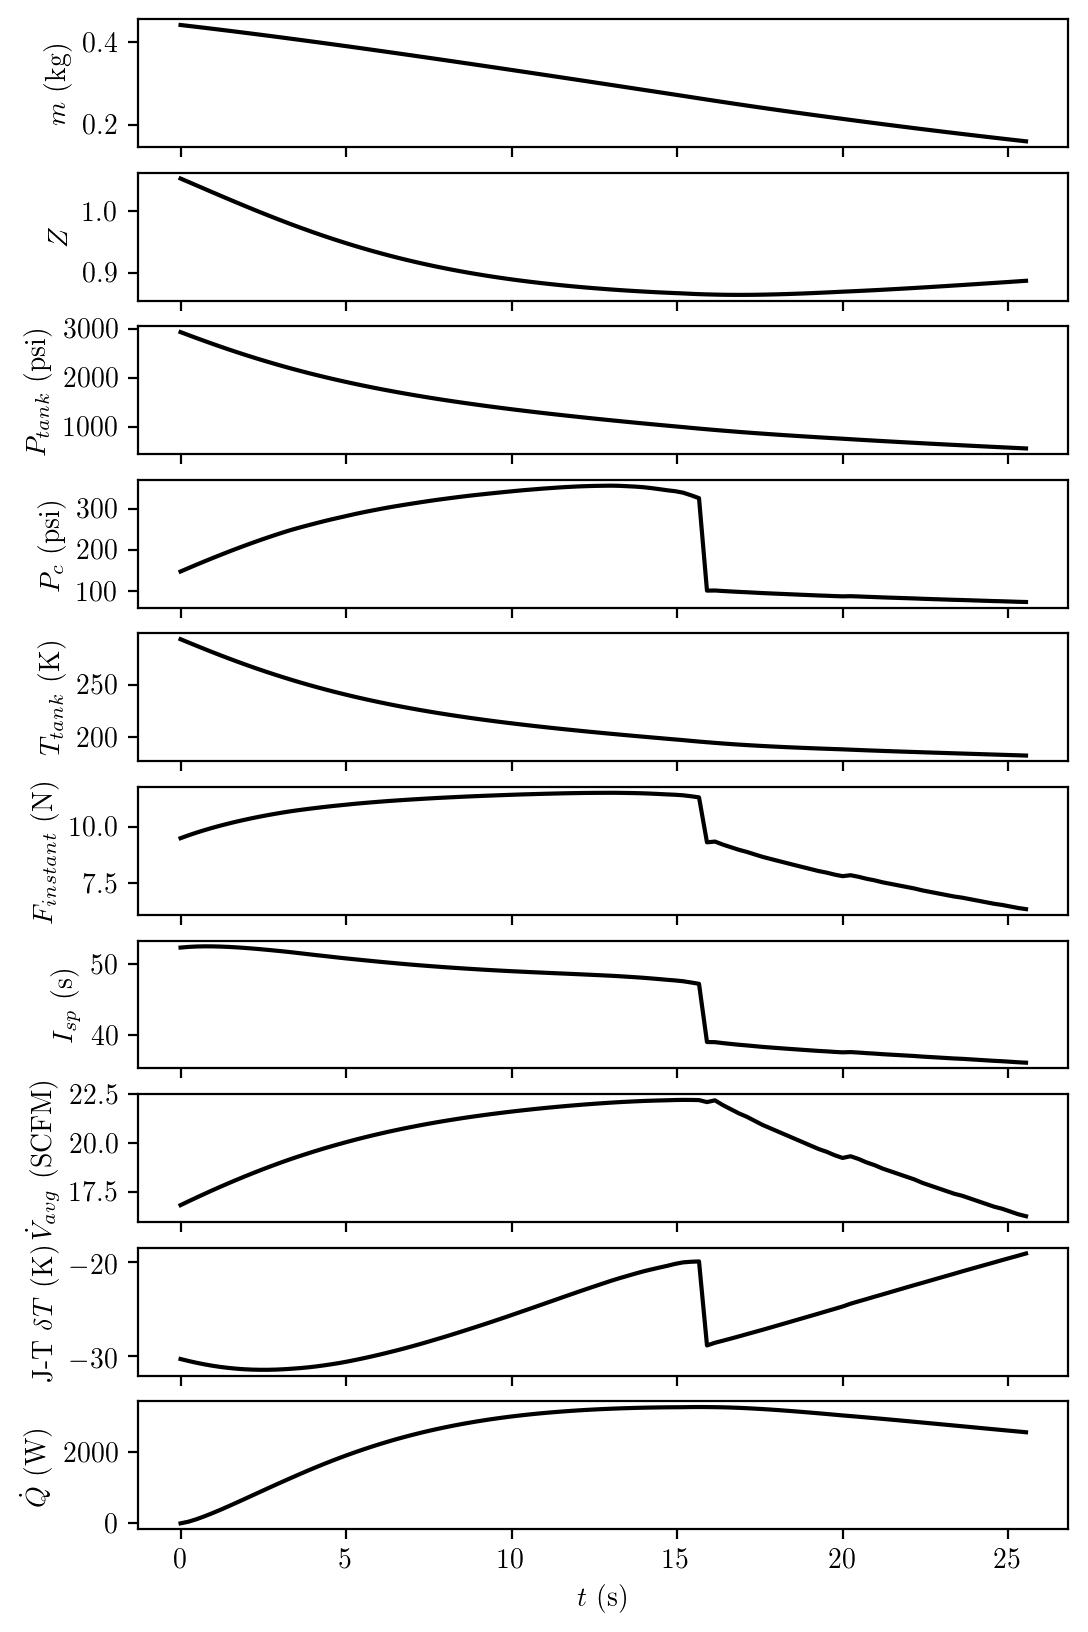

Cold condition
max V_SCFM: 44.41 SCFM (GN2)
min T_tank: 182.88 K
min P_tank: 560.95 psi 

Hot condition
min V_SCFM: 32.52 SCFM (GN2)
max P_tank: 2935.04 psi 

t final: 25.54 s
initial pressurant mass: 0.44 kg
average Isp: 45.17 s
min thrust: 6.35 N
max thrust: 11.52 N
total impulse: 124.85 N*s
max p_c: 355.44 psi 

final flowrate: 32.52 SCFM
final pressure: 74.15 psi


In [25]:
# Inputs
fluid = 'Nitrogen'
p_0 = 3000 * ureg.psi # tank inital pressure, psia
T_0 = 293 # tank inital temperature, K
volume = 0.002 # tank volume (2 L), m^3
Q = 0. # heat transfer to tank CV, W
Cd = 0.6 # discharge coefficient
p_e = 101352.9 # ambient pressure, Pa
A = np.pi * (1E-3)**2 # throat area, m^2
mdot = 0.01 # mass flow rate from tank CV, kg/s
p_reg = convert_units(200 * ureg.psi, 'pascal') # regulator set-pressure, psia
duty = 0.5 # control-valve duty cycle
accel = 5. # tank acceleration, g's

"""
*Note* mdot, duty, p_reg and Q are optional args
if mdot is not specified a choked orifice is default
if duty is not specified a 100% duty cycle is default, 
if p_reg is not specified the orifice upstream pressure is the tank pressure
if Q is not specified internal free-convection heat transfer is default
"""

sol, t, params = main(p_0, T_0, fluid, ureg, p_e=p_e, 
                      A=A, volume=volume, duty=duty, p_reg=p_reg, accel=accel)

In [21]:
fluid = 'Nitrogen'
fclib = gen_flow_curve_library(convert_units(100 * ureg.psi, 'pascal'), fluid)
p_t = 12020688
mdot = 0.019882767956857565
#0.019882767956857565 12020688.807088174
print(scfm(0.019882767956857565, 'to', 'Nitrogen'))
print(convert_units(12020688.807088174*ureg.pascal, 'psi'))
#p_fc = get_p_fc(12020688.807088174)
#p_fc(mdot)

36.14340667232136
1743.4535105389164


## Scratch
### How to get droop
- droop is difficult, needs an interative method becuase of mdot coupling with outlet pressure & temperature
- also need to interpolate between flow curves (P_out vs. V_scfm), which are functions of inlet pressure

<div>
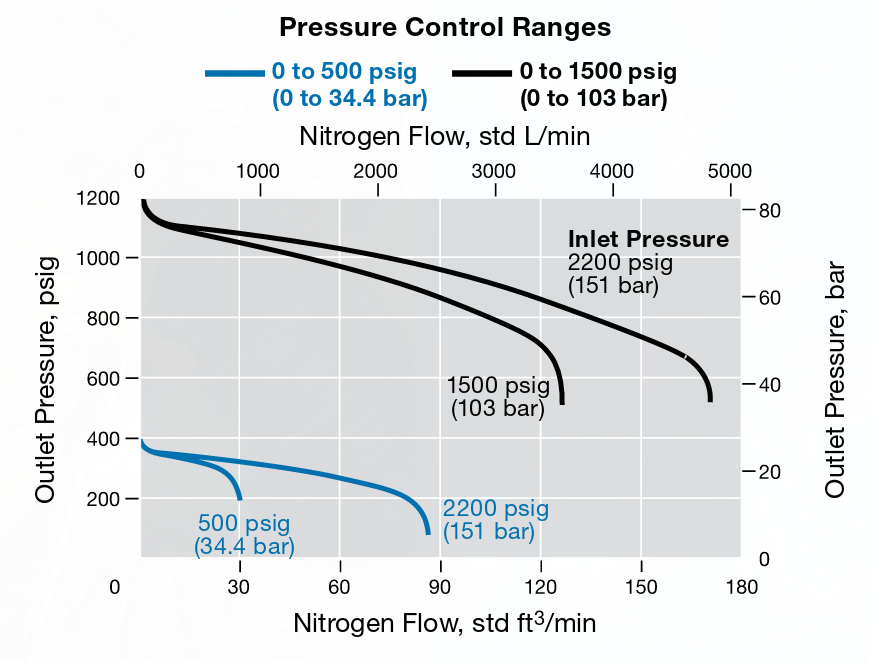
</div>

### Pseudocode
1. get 2 or 3 curves with webplotdigitizer
2. interp in between curves corresponding to upstream pressures
3. convert flow units to kg/s, pressure units to Pa
4. vertical shift by set pressure 
5. get nearest flow curve given tank pressure
6. use p_c, T_c, and mdot global vars for initial guess
7. p_c() func does 1d interpolation of curve to get p_c given flow
8. use scipy.optimize.fsolve to get m_dot(p_c, T_c), T_c(p_c), and p_c(mdot)

In [22]:
fluid = 'Nitrogen'
fclib = gen_flow_curve_library(convert_units(300 * ureg.psi, 'pascal'), fluid)

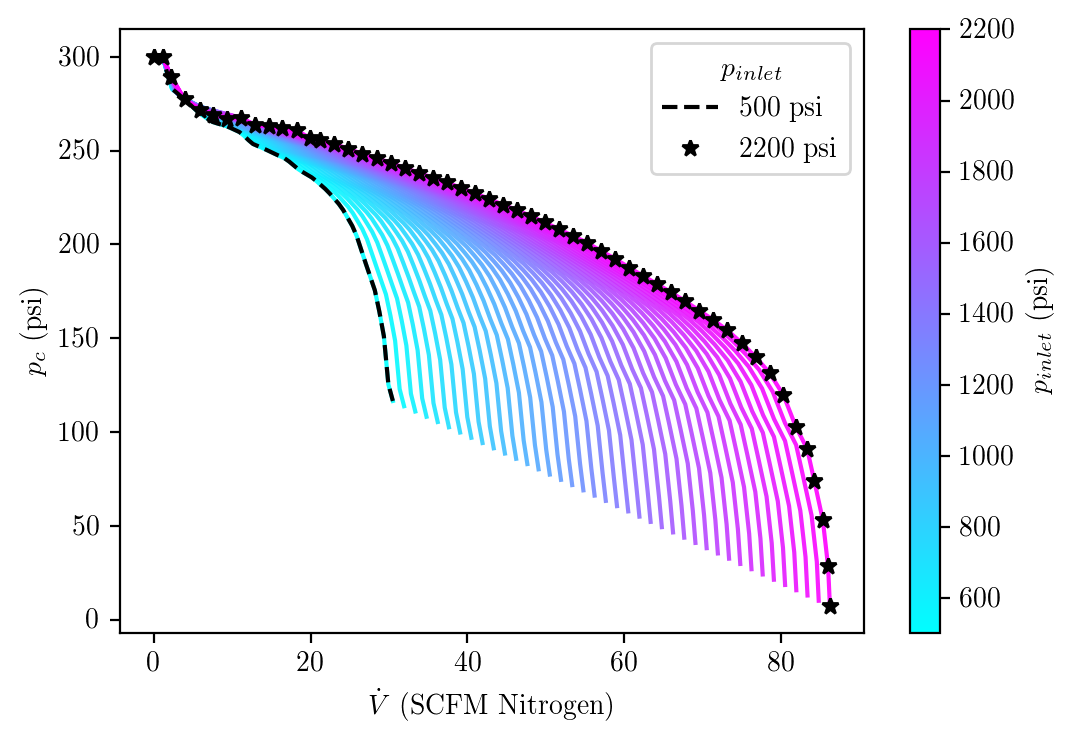

In [23]:
# experimental flow curves from https://www.swagelok.com/downloads/webcatalogs/EN/MS-02-230.PDF
# swagelok KCP regulator, Cv=0.2
# data digitized from images using https://apps.automeris.io/wpd/

import matplotlib as mpl

fig = plt.figure(dpi=100)
color_idx = np.linspace(0, 1, len(fclib))
norm = mpl.colors.Normalize(vmin=500, vmax=2200)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.cool)
cmap.set_array([])

for i, j in zip(color_idx, fclib.keys()):
    mdot, p = fclib[j][:,0], fclib[j][:,1]
    mdot = scfm(mdot, 'to', 'nitrogen')
    p = convert_units(p*ureg.pascal, 'psi')
    plt.plot(mdot, p, color=plt.cm.cool(i), alpha=0.9)
    
fig.colorbar(cmap, label='$p_{inlet}$ (psi)')

plt.plot(scfm(fclib[min(fclib.keys())][:,0], 'to', 'nitrogen'), 
         convert_units(fclib[min(fclib.keys())][:,1]*ureg.pascal, 'psi'), 
         'k--', label='{:0.0f} psi'.format(500))

plt.plot(scfm(fclib[max(fclib.keys())][:,0], 'to', 'nitrogen'), 
         convert_units(fclib[max(fclib.keys())][:,1]*ureg.pascal, 'psi'), 
         'k*', label='{:0.0f} psi'.format(2200))

plt.legend(title='$p_{inlet}$')
plt.ylabel('$p_{c}$ (psi)')
plt.xlabel('$\dot{V}$ (SCFM Nitrogen)')
plt.show()